In [ ]:
!pip3 install lmfit
import lmfit as lm
import numpy as np
import pandas as pd
import glob
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


The E can be looked up - 
what we do is find the bin number where the counts are highest for each substance, and find a linear relationship accross all substances
From there, we can interpolate what the unknown substances are
we graph
we want to have a graph of counts over energy


In [ ]:
#interpolation of unknown substances

#y = mx + b => y = 0.264x + 33.6

#bins of unknowns 
unknown_1 = 2405
unknown_2 = 3986
energy_1 = (0.264 * unknown_1) + 33.6
energy_2 = (0.264 * unknown_2) + 33.6
print("First unknown", energy_1, "KeV")
print("Second unknown", energy_2, "KeV")

#first is cs137
#second is zn65, 1130

error_1 = (energy_1 - 661.17)/661.17
error_2 = -(energy_2 - 1130)/1130

print("Percent Error of Energy for Cs-137", error_1*100)
print("Percent Error of Energy for Zn-65", error_2*100)

First unknown 668.5200000000001 KeV
Second unknown 1085.904 KeV
Percent Error of Energy for Cs-137 1.1116656835609808
Percent Error of Energy for Zn-65 3.9023008849557526


Interpolated Number of Counts with No Shielding 4166.394611779839
Interpolated Number of Counts with No Shielding, WG 3299.1669616213753
3299.1669616213753 3018
0    12.909513
1    19.952572
2    11.443765
3     3.362008
Name: Sheilding (mg/cm^2), dtype: float64
[3018 2196  699  643] 0    0.0069
1    0.0204
2    0.1356
3    0.4864
Name: Sheilding (mg/cm^2), dtype: float64


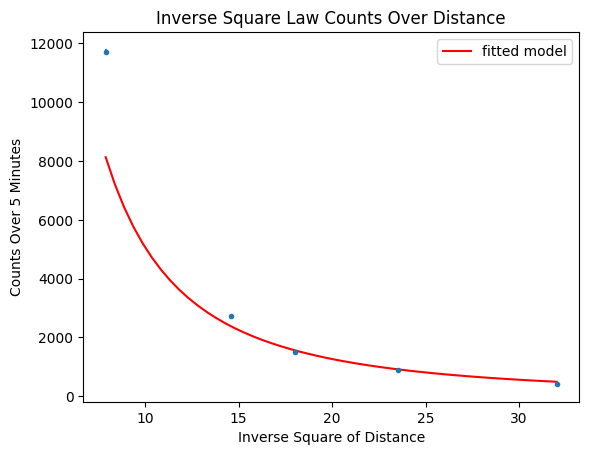

<Figure size 640x480 with 0 Axes>

In [ ]:
Noise = 229
dist_offset = 2.0
def inv_sq(x, a):
  return a / (x * x)

df = pd.read_csv('/GAM_Lab/GAM Lab/Square.csv')

inv_sq_counts = np.array(df['Counts (N+B)']) - Noise
inv_sq_dist = np.array(df['Radius (cm)']) + dist_offset

inv_sq_model = lm.models.Model(inv_sq)
inv_sq_model.set_param_hint('a', value = inv_sq_counts[0])
# inv_sq_model.set_param_hint('b', value = 0)

inv_sq_weights = 1.0 / inv_sq_counts

inv_sq_params = inv_sq_model.make_params()

inv_sq_result = inv_sq_model.fit(inv_sq_counts, x = inv_sq_dist, weights = inv_sq_weights, params = inv_sq_params)

plt.errorbar(inv_sq_dist, inv_sq_counts, yerr = np.sqrt(inv_sq_counts), fmt = '.')
x_fit = np.linspace(np.amin(inv_sq_dist), np.amax(inv_sq_dist), 50)

y_fit = inv_sq_result.eval(x = x_fit)
plt.plot(x_fit, y_fit, 'r', label = 'fitted model')
plt.xlabel('Inverse Square of Distance')
plt.ylabel('Counts Over 5 Minutes')
plt.title('Inverse Square Law Counts Over Distance')
plt.legend()
plt.figure()

# exponential fit y = 26434e^-0.149x
e = np.e
radius = 10.4 + dist_offset
x = radius
counts_interp = 26434*(e**(-0.149*x))

print("Interpolated Number of Counts with No Shielding", counts_interp)
counts_interp = inv_sq_result.eval(x = radius)
print("Interpolated Number of Counts with No Shielding, WG", counts_interp)



N_0 = counts_interp



df = pd.read_csv('/GAM_Lab/GAM Lab/Beer.csv')

#for aluminum mu/rho = 7.467*10^-2 cm^2/g
#mu_over_rho_al = 7.467 * 10^(-2)
N = np.array(df['Counts (N+B)']) - Noise
print(N_0, N[0])
rhoL = df['Sheilding (mg/cm^2)'] / 1000.0
mu_over_rho = (np.log(N/N_0))/(-rhoL)
print(mu_over_rho)
#print("Areal Density", np.mean(mu_over_rho))

#plt.errorbar(rhoL, mu_over_rho_al, yerr = np.sqrt(N), fmt ='.')

print(N, rhoL)



N_0 2893.4911632740027 64.25345566991454
mu/rho 29.917774847457753 1.4767772180839325
N_scatt 642.999972465581 17.153709261660094


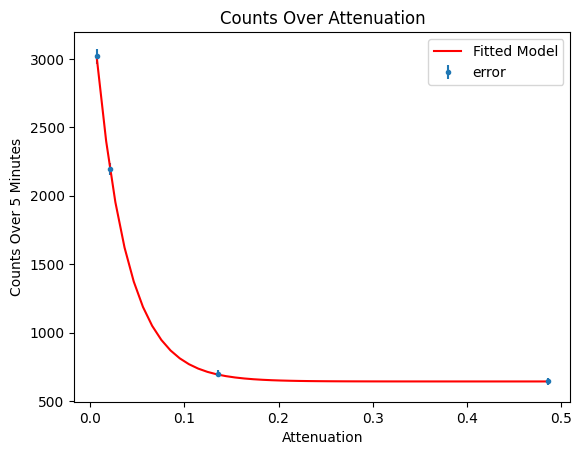

<Figure size 640x480 with 0 Axes>

In [ ]:
def beer(x,a,b,c):
  return a * np.e**(-b*x) + c
beer_model = lm.models.Model(beer)
beer_model.set_param_hint('a', value = N_0)
beer_model.set_param_hint('b', value = 0.07)
beer_model.set_param_hint('c', value = 0.1, min = 0, max = N[-1])
my_params = beer_model.make_params()
weights = 1.0/N
my_result = beer_model.fit(N, x = rhoL, params = my_params, weights = weights)
x_fit = np.linspace(np.amin(rhoL), np.amax(rhoL), 50)
y_fit = my_result.eval(x=x_fit)
plt.errorbar(rhoL, N, yerr = np.sqrt(N), fmt = '.', label = 'error')
plt.plot(x_fit, y_fit, 'r', label = 'Fitted Model')
plt.xlabel('Attenuation')
plt.ylabel('Counts Over 5 Minutes')
plt.title('Counts Over Attenuation')
plt.legend()
plt.figure()
print('N_0', my_result.params['a'].value, my_result.params['a'].stderr)
print('mu/rho', my_result.params['b'].value, my_result.params['b'].stderr)
print('N_scatt', my_result.params['c'].value, my_result.params['c'].stderr)

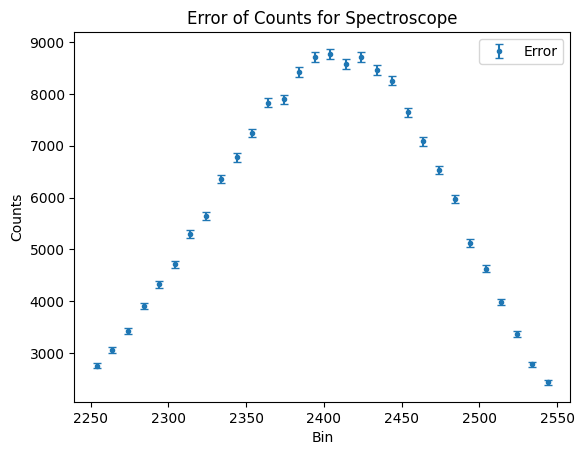

In [ ]:
df = pd.read_csv('/GAM_Lab/GAM Lab/GAM Lab - Cs-137 error.csv')
x = df['Bin']
y = df['Count']

start_index = x[x == 2254].index[0]
end_index = x[x == 2554].index[0] + 1
x_trunc = x[start_index:end_index]
y_trunc = y[start_index:end_index]

bins = np.arange(2254, 2555, 10)
x_bin = np.histogram(x_trunc, bins=bins)[1][:-1]
y_bin = np.histogram(x_trunc, bins=bins, weights=y_trunc)[0]

y_err = np.sqrt(y_bin)

plt.errorbar(x_bin, y_bin, yerr=y_err, fmt='.', capsize=3, label='Error')
plt.ylabel('Counts')
plt.xlabel('Bin')
plt.title('Error of Counts for Spectroscope')
plt.legend()
plt.show()

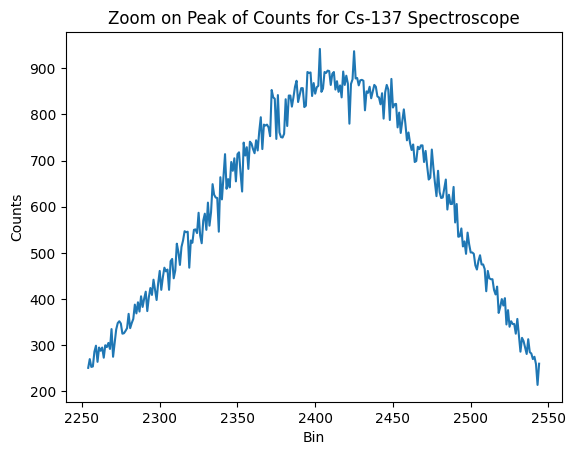

In [ ]:

df = pd.read_csv('/GAM_Lab/GAM Lab/GAM Lab - Cs-137 error.csv')
x = df['Bin']
y = df['Count']

# Slice the 'x' and 'y' arrays to include only values from 2254 to 2454
start_index = x[x == 2254].index[0]
end_index = x[x == 2544].index[0] + 1
x_sliced = x[start_index:end_index]
y_sliced = y[start_index:end_index]

plt.ylabel('Counts')
plt.xlabel('Bin')
plt.title('Zoom on Peak of Counts for Cs-137 Spectroscope')

plt.plot(x_sliced, y_sliced)
plt.show()